In [1]:
import numpy as np, h5py
import matplotlib.pyplot as plt
%matplotlib inline

estimatedRes  = h5py.File('EstimatedResponses.mat','r')
estimatedRes.keys()

[u'dataTrnS1',
 u'dataTrnS2',
 u'dataValS1',
 u'dataValS2',
 u'roiS1',
 u'roiS2',
 u'voxIdxS1',
 u'voxIdxS2']

In [2]:
# Validation data
subj1Val = np.array(estimatedRes['dataValS1'])
subj2Val = np.array(estimatedRes['dataValS2'])

In [3]:
# Brain data
subj1Train = np.array(estimatedRes['dataTrnS1'])
subj2Train = np.array(estimatedRes['dataTrnS2'])

In [4]:
# Regions of interest
regionInterest1 = estimatedRes['roiS1'][0]
regionInterest2 = estimatedRes['roiS2'][0]

#### --- The following cells load, rescale, filter and featurize images. Skip this section if you dont have the image dataset --- 

In [5]:
# Loading Train Images
imagesFullRes  = h5py.File('Stimuli_Trn_FullRes_01.mat','r')
imagesFullRes = imagesFullRes['stimTrn'][:].T

for i in range(2,10):
    imageFile  = h5py.File('Stimuli_Trn_FullRes_0' + str(i) + '.mat','r')
    imagesFullRes = np.vstack([imagesFullRes , imageFile['stimTrn'][:].T])
    
for i in range(10,16):
    imageFile  = h5py.File('Stimuli_Trn_FullRes_' + str(i) + '.mat','r')
    imagesFullRes = np.vstack([imagesFullRes , imageFile['stimTrn'][:].T])

imagesFullRes.shape

(1750L, 500L, 500L)

In [6]:
# Loading Validation Images
valImgFull = h5py.File('Stimuli_Val_FullRes.mat','r')
valImgFull =  valImgFull['stimVal'][:].T

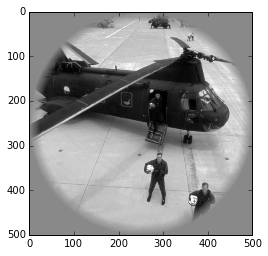

In [7]:
plt.imshow(imagesFullRes[1749], cmap='gray')

In [8]:
# Resizing Train Images
import scipy.misc as scipyMisc
resizedImages = []
for img in imagesFullRes:
    resizedImages.append(scipyMisc.imresize(img, size=(200,200)))

resizedImages = np.asarray(resizedImages)
resizedImages.shape

(1750L, 200L, 200L)

In [9]:
# Resizing Validation Images
resValImages = []
for img in valImgFull:
    resValImages.append(scipyMisc.imresize(img, size=(200,200)))

resValImages = np.asarray(resValImages)
resValImages.shape

(120L, 200L, 200L)

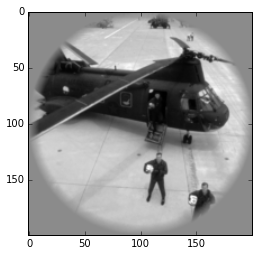

In [10]:
plt.imshow(resizedImages[1749], cmap='gray')

In [11]:
# Gabor filters
import cv2

# 5 scales and 8 orientations
def build_filters():
    scales = [200, 100, 50, 25, 10]
    filters = []
    for scal in scales:
        for theta in np.arange(0, np.pi, np.pi / 6):
            kern = cv2.getGaborKernel((scal, scal), 4.0, theta, 0.5, 1, 0, ktype=cv2.CV_32F)
            kern2 = cv2.getGaborKernel((scal, scal), 4.0, theta, 0.5, 1, np.pi/2.0, ktype=cv2.CV_32F)
            #kern /= 1.5*kern.sum()
            #kern2 /= 1.5*kern2.sum()
            filters.append(kern)
            filters.append(kern2)
    return np.asarray(filters)

def process(img, filters):
    convImg = []
    for kern in filters:
        accum = np.zeros_like(img)
        cv2.filter2D(src=img, ddepth=cv2.CV_8UC3, dst=accum, kernel=kern)
        convImg.append(accum)
    return np.asarray(convImg)

filters = build_filters()
filters.shape

(60L,)

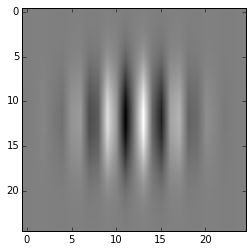

In [12]:
plt.imshow(filters[47], cmap='gray')

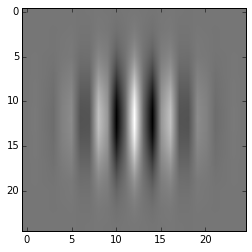

In [13]:
plt.imshow(filters[46], cmap='gray')

In [15]:
# Filtering Train images
filteredImg = []
for img in resizedImages:
    filteredImg.append(process(img, filters))

filteredImg = np.asarray(filteredImg)

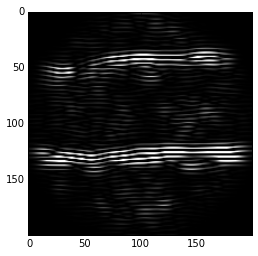

In [16]:
plt.imshow(filteredImg[102][20], cmap='gray')

In [17]:
# Filtering Validation images
filteredValImg = []
for img in resValImages:
    filteredValImg.append(process(img, filters))

filteredValImg = np.asarray(filteredValImg)

In [18]:
# extracting Local Energy features - Train
localEnergyFeat = []

for img in filteredImg:
    features = []
    for feat in img:
        alpha = np.dot(feat.flatten(), feat.flatten())
        features.append(np.sqrt(alpha))
    localEnergyFeat.append(features)
    
localEnergyFeat = np.asarray(localEnergyFeat)

In [19]:
localEnergyFeat.shape

(1750L, 60L)

In [20]:
# extracting Local Energy features - Validation
valLocalEnergyFeat = []

for img in filteredValImg:
    features = []
    for feat in img:
        alpha = np.dot(feat.flatten(), feat.flatten())
        features.append(np.sqrt(alpha))
    valLocalEnergyFeat.append(features)
    
valLocalEnergyFeat = np.asarray(valLocalEnergyFeat)

In [21]:
# extracting Mean Amplitude - Train
meanAmpFeat = []

for img in filteredImg:
    features = []
    for feat in img:
        alpha = np.sum(np.absolute(feat.flatten()))
        features.append(alpha)
    meanAmpFeat.append(features)
    
meanAmpFeat = np.asarray(meanAmpFeat)

In [22]:
meanAmpFeat.shape

(1750L, 60L)

In [23]:
# extracting Mean Amplitude - Validation
valMeanAmpFeat = []

for img in filteredValImg:
    features = []
    for feat in img:
        alpha = np.sum(np.absolute(feat.flatten()))
        features.append(alpha)
    valMeanAmpFeat.append(features)
    
valMeanAmpFeat = np.asarray(valMeanAmpFeat)

In [24]:
# Combine feature vectors - Train
featImgs = []

for locEng, meanAmp in zip(localEnergyFeat, meanAmpFeat):
    featImgs.append(np.hstack((locEng, meanAmp)))
    
featImgs = np.asarray(featImgs)
featImgs.shape

(1750L, 120L)

In [25]:
# Combine feature vectors - Validation
featValImgs = []

for locEng, meanAmp in zip(valLocalEnergyFeat, valMeanAmpFeat):
    featValImgs.append(np.hstack((locEng, meanAmp)))
    
featValImgs = np.asarray(featValImgs)
featValImgs.shape

(120L, 120L)

In [26]:
np.save('featImgs',featImgs)
np.save('featValImgs', featValImgs)

#### -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
featImgs = np.load('featImgs.npy')
featValImgs = np.load('featValImgs.npy')

### Linear Regression Voxel 1

In [27]:
from sklearn.linear_model import LinearRegression

In [28]:
classifier = LinearRegression()
voxel = 17589

In [29]:
indx = np.where( np.logical_not(np.isnan(subj1Train[:,voxel])))
indx = indx[0]

In [30]:
classifier.fit(featImgs[indx], subj1Train[indx,voxel])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [31]:
indxVal = np.where( np.logical_not(np.isnan(subj1Val[:,voxel])))
indxVal = indxVal[0]

In [32]:
predictions = classifier.predict(featValImgs[indxVal])

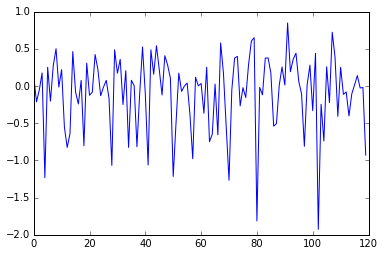

In [33]:
plt.plot(predictions)

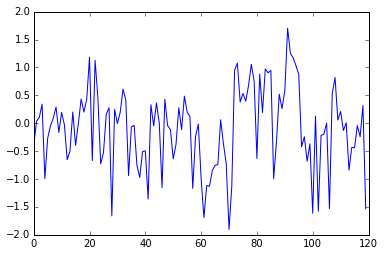

In [34]:
plt.plot(subj1Val[indxVal,voxel])

In [35]:
classifier.score(featValImgs[indxVal],subj1Val[indxVal,voxel])

0.4256087759738798

### Voxels with best Prediction Score

In [36]:
voxelScores = []
for vox in range(subj1Val.shape[1]):
    classifierVox = LinearRegression()
    indx = np.where( np.logical_not(np.isnan(subj1Train[:,vox])))
    indx = indx[0]
    if indx.size == 0:
        continue
    classifierVox.fit(featImgs[indx], subj1Train[indx,vox])
    indxVal = np.where( np.logical_not(np.isnan(subj1Val[:,vox])))
    indxVal = indxVal[0]
    if indxVal.size == 0:
        continue
    score = classifierVox.score(featValImgs[indxVal],subj1Val[indxVal,vox])
    voxelScores.append((score, vox))

In [42]:
sortedScores = sorted(voxelScores, key=lambda x: x[0], reverse=True)
#sortedScores[:500]

In [39]:
topVoxels = [voxel for _,voxel in sortedScores[:500]]

In [40]:
topRegions = [regionInterest1[vox] for vox in topVoxels]

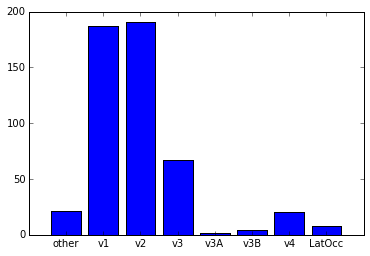

In [41]:
from collections import Counter

regCount = Counter(topRegions)
plt.bar(range(len(regCount)), regCount.values(), align='center')
plt.xticks(range(len(regCount)), ['other', 'v1', 'v2', 'v3', 'v3A', 'v3B', 'v4', 'LatOcc'])
plt.show()